<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [11.0 Predictive Models Informed by Simulation, Measurement, and Surrogates](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.00-Predictive-Models-Informed-by-Simulation-Measurement-and-Surrogates.html) | [Contents](toc.html) | [11.2 Markov Chain Monte Carlo Examples](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/11.01-Gibbs-Sampling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.01-Gibbs-Sampling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 11.1 Gibbs Sampling to Approximate Bayes' Integral

Created by Pedro Amorim (pamorimv@nd.edu)

The following text, examples, and codes were adapted from these sources:
* McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 8: Reliability Methods for Estimating the Probability of Failure, Springer, https://doi.org/10.1007/978-3-319-99525-0_8
* McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 11: Predictive Models Informed by Simulation, Measurement, and Surrogates, https://link.springer.com/chapter/10.1007/978-3-319-99525-0_11
* Yildirim, Ilke (2012). Bayesian Inference: Gibbs Sampling, http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf

Models can be used to fuse experimental and simulation data, as long as we attend to the dissonances between those two. To do that, we can use calibration techniques to account for those dissonances. One of the ways to combine simulation and experimental, or, better saying deterministic and stochastic data to use Bayes' rule.

$$\pi(t,\epsilon | y,x) = \frac{f(y|x,t,\epsilon)\pi(t)\pi(\epsilon)}{\int dt \int d \epsilon f(y|x,y,\epsilon)\pi(t)\pi(\epsilon)}$$


The likelihood, if assumed to be normal (for example), can be solved. This way we will have a closed form for the prior.

$$f(y|x,t,\epsilon) = \frac{1}{2\pi^{N/2}\sigma^N} exp{\left[ -\frac{1}{2\sigma^2} \sum_{i=1}^{N} (y(x_i) - \eta(x_i,t_i))^2\right]}$$

But if you don't know the measurement error, you will have to evaluate the denominator of Bayes' rule, and after each step re-evaluate your QoI. This process can become not only very tedious, but also very expensive as your model becomes more complex. To avoid this numerical integration, you can approximate your integral via several methods. **The one discussed in this notebook will be Gibbs Sampling**, although other methods such as Markov Chain Monte Carlo.

Assume that you have a joint distribution of two variables $\theta_1$ and $\theta_2$ about and **can** sample the conditional distribution of a bivariate distribution $p(\theta_1 | \theta_2)$ and $p(\theta_2 | \theta_1)$.

To conduct Gibbs Sampling, you should follow these steps:
1. Give an initial value for $\theta_1^{(0)}$ and $\theta_2^{(0)}$
2. Sample $\theta_1^{(j)}$ from the conditional distribution p($\theta_1|\theta_2^{(j-1)})$
3. Sample $\theta_2^{(j)}$ from the conditional distribution p($\theta_2|\theta_1^{(j)})$

Gibbs Sampling is yet another Markov Chain. The Markov characteristic lies on the fact that the the next value for a parameter solely depend on the knowledge of its current value, and not on its previous values. 
**This method will fail if you have independent variables.**
According to the law of large numbers, and the central limit theorem, the average of the results of this Gibbs Sampling will generate the expectation  value of the quantity you are trying to measure.

### 11.1.1 Example: Multivariate distribution

Suppose you have a multivariate distribution $\theta$ ~ $N_2(0,\Sigma)$ with $\Sigma =$  $$\begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}$$


The conditional distribution for each of these variables is given by:

$\theta_1 | \theta_2$ ~ $N(\rho\theta_2,[1-\rho^2]$)

$\theta_2 | \theta_1$ ~ $N(\rho\theta_1,[1-\rho^2]$)

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
mean_x = 0
variance_x = 1
cor_xy = 0.3

mean_y = 0
variance_y = 1
cor_yx = cor_xy

x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)
xgrid,ygrid = np.meshgrid(x,y)

In [3]:
position = np.empty(xgrid.shape + (2,))
position[:,:, 0] = xgrid
position[:,:, 1] = ygrid

gauss2d = stats.multivariate_normal([mean_x, mean_y], [[variance_x, cor_xy], [cor_yx, variance_y]]) 

<a list of 10 text.Text objects>

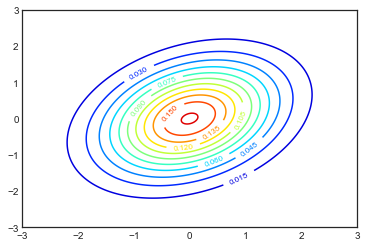

In [4]:
img = plt.contour(xgrid,ygrid,gauss2d.pdf(position),15,cmap = 'jet')
plt.clabel(img, inline=True, fontsize=8)

In [5]:
def gibbs_sampler(dist1_i,dist2_i,correl,steps):
    """
    Returns values for a bivariate normal distribution using Gibbs Sampling.
    
    Parameters
    ----------
    dist1_i, dist2_i : float
        The initial guesses for each variable
    
    correl : float
        The correlation between the two variables.

    Returns
    -------
    count : list(int)
        Steps conducted in the Gibbs Sampling.
        
    val_1 : list(float)
        Values for the variable 1 after running Gibbs Sampling.
    
    val_2 : list(float)
        Values for the variable 2 after running Gibbs Sampling.
    """
    #Initializing empty lists
    count = []
    val_1 = []
    val_2 = []
    
    #Appending initial values to each one of the return variables
    count.append(0)
    val_1.append(dist1_i)
    val_2.append(dist2_i)
    
    #Running Gibbs Sampling
    for i in range(steps):
        val_1.append(np.random.normal(val_2[i]*correl, 1 - correl**2))
        val_2.append(np.random.normal(val_1[i+1]*correl, 1 - correl**2))
        count.append(i+1)
    
    return [count,val_1,val_2]
    

In [6]:
#Running Gibbs Sampling 100 times with the initial guesses (-2,2) 
iterations,xvals,yvals = gibbs_sampler(-2,2,cor_xy,100)

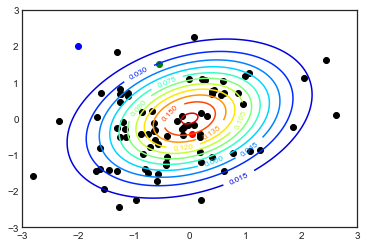

In [7]:
#Plotting the results:
img = plt.contour(xgrid,ygrid,gauss2d.pdf(position),15,cmap = 'jet')
plt.clabel(img, inline=True, fontsize=8)
plt.scatter(xvals[0],yvals[0], c='blue')
plt.scatter(xvals[1],yvals[1],c='red')
plt.scatter(xvals[2],yvals[2],c='green')
plt.scatter(xvals[21:],yvals[21:],c='black')
plt.show()

In [8]:
#Running Gibbs Sampling 100 times with the initial guesses (3,3) 
iterations,xvals,yvals = gibbs_sampler(3,3,cor_xy,100)

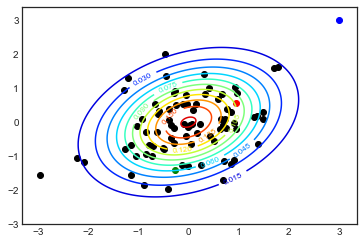

In [9]:
#Plotting the results:
img = plt.contour(xgrid,ygrid,gauss2d.pdf(position),15,cmap = 'jet')
plt.clabel(img, inline=True, fontsize=8)
plt.scatter(xvals[0],yvals[0], c='blue')
plt.scatter(xvals[1],yvals[1],c='red')
plt.scatter(xvals[2],yvals[2],c='green')
plt.scatter(xvals[21:],yvals[21:],c='black')
plt.show()

### 11.1.2 When will the method break?

Gibbs Sampling will not perform well in cases where the two (or more variables) are independent from one another (the conditional probability of two independent variables is zero).

Furthermore, the method will probably perform poorly in situtations where your surface contains several minima/maxima. In this case, we will most likely have uneven sampling of the several basins we will have in the system.

Below let's see an example with two independent variables.

In [10]:
def f1(x,y):
    return np.exp(np.sin(x) + np.cos(y))

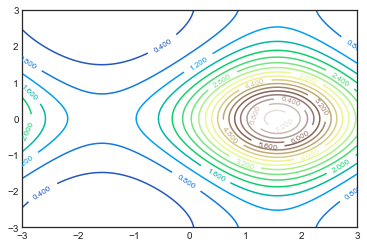

In [11]:
zgrid = f1(xgrid,ygrid)
img = plt.contour(xgrid,ygrid,zgrid, 20, cmap = 'terrain')
plt.clabel(img, inline=True, fontsize=8)
plt.show()

In [12]:
def gibbs_sampler_f1(guess1_i,guess2_i,steps):
    count = []
    val_1 = []
    val_2 = []
    
    count.append(0)
    val_1.append(guess1_i)
    val_2.append(guess2_i)
    
    for i in range(steps):
        val_1.append(np.exp(np.cos(val_2[i])))
        val_2.append(np.exp(np.sin(val_1[i+1])))
        count.append(i+1)
    
    return [count,val_1,val_2]
    

In [13]:
iter_f1,xvals_f1,yvals_f1 = gibbs_sampler_f1(0,0,1000)

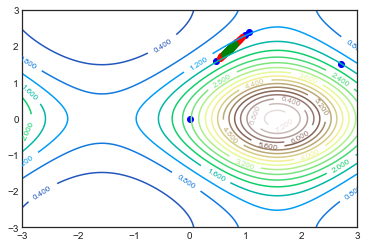

In [14]:
zgrid = f1(xgrid,ygrid)
img2 = plt.contour(xgrid,ygrid,zgrid, 20, cmap = 'terrain')
plt.clabel(img2, inline=True, fontsize=8)
plt.scatter(xvals_f1[0:5],yvals_f1[0:5], c='blue')
plt.scatter(xvals_f1[6:20],yvals_f1[6:20],c='red')
plt.scatter(xvals_f1[21:],yvals_f1[21:],c='green')


In [15]:
iter_f2,xvals_f2,yvals_f2 = gibbs_sampler_f1(-3,0,1000)

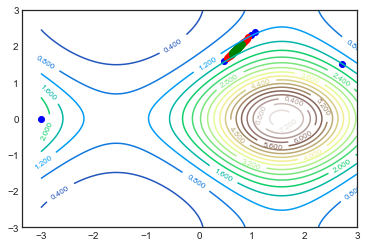

In [16]:
zgrid = f1(xgrid,ygrid)
img3 = plt.contour(xgrid,ygrid,zgrid, 20, cmap = 'terrain')
plt.clabel(img3, inline=True, fontsize=8)
plt.scatter(xvals_f2[0:5],yvals_f2[0:5], c='blue')
plt.scatter(xvals_f2[6:20],yvals_f2[6:20],c='red')
plt.scatter(xvals_f2[21:],yvals_f2[21:],c='green')

<!--NAVIGATION-->
< [11.0 Predictive Models Informed by Simulation, Measurement, and Surrogates](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.00-Predictive-Models-Informed-by-Simulation-Measurement-and-Surrogates.html) | [Contents](toc.html) | [11.2 Markov Chain Monte Carlo Examples](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/11.01-Gibbs-Sampling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.01-Gibbs-Sampling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>